In [1]:
import sys, os
sys.path.insert(1,os.path.join(".."))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



import fmdtools.faultsim as fs
import fmdtools.resultdisp as rd
import quadpy
from IPython.display import HTML
from fmdtools.modeldef import SampleApproach
from fmdtools.modeldef import Model

## Initial Model


In our initial model, all we have is the flows, functions, and connections between them. These are set up in a model class as shown:

In [2]:
class Drone(Model):
    def __init__(self, params={}):
        super().__init__()
        self.params=params
        #add flows to the model
        self.add_flow('Force_ST', {})
        self.add_flow('Force_Lin', {})
        self.add_flow('Force_GR' , {})
        self.add_flow('Force_LG', {})
        self.add_flow('EE_1', {})
        self.add_flow('EEmot', {})
        self.add_flow('EEctl', {})
        self.add_flow('Ctl1', {})
        self.add_flow('DOFs', {})
        self.add_flow('Env1', {})
        self.add_flow('Dir1', {})
        #add functions to the model
        flows=['EEctl', 'Force_ST']
        self.add_fxn('StoreEE',['EE_1', 'Force_ST'])
        self.add_fxn('DistEE', ['EE_1','EEmot','EEctl', 'Force_ST'])
        self.add_fxn('AffectDOF',['EEmot','Ctl1','DOFs','Force_Lin'])
        self.add_fxn('CtlDOF', ['EEctl', 'Dir1', 'Ctl1', 'DOFs', 'Force_ST'])
        self.add_fxn('Planpath', ['EEctl', 'Env1','Dir1', 'Force_ST'])
        self.add_fxn('Trajectory', ['Env1','DOFs','Dir1', 'Force_GR'] )
        self.add_fxn('EngageLand',['Force_GR', 'Force_LG'])
        self.add_fxn('HoldPayload',['Force_LG', 'Force_Lin', 'Force_ST'])
        self.add_fxn('ViewEnv', ['Env1'])
        
        self.build_model()

## Setting Node Positions

As shown below, it can be difficult to make sense of a model structure using the default shell graph layout. We might instead want to see something that more closely approximates a flow chart of the system.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

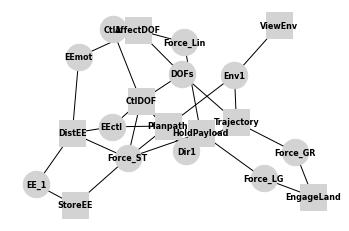

In [3]:
mdl = Drone()
rd.graph.show(mdl)

To set node positions, we can use ``rd.graph.set_pos()``, which lets one drag the nodes to their desired locations. If a model is sent to ``set_pos``, it will set those locations in the model going forward, though it is good practice to save node locations when one is done in the script or the model class file (they can be used as inputs to ``construct_graph()``.

In [4]:
%matplotlib qt5
pos = rd.graph.set_pos(mdl)
pos

{'StoreEE': [0.9789191723174281, 0.07570358410460433],
 'Dir1': [0.6689046782688534, 0.03500710850331211],
 'AffectDOF': [0.26942443840768615, 0.1277035726863881],
 'HoldPayload': [0.43898792812182397, 0.8909704585850113],
 'CtlDOF': [0.13373758347952144, 0.575969126237474],
 'Force_Lin': [0.582138066607873, 0.7803120714959938],
 'DOFs': [0.5459589259848906, 0.4372894940119511],
 'EEmot': [0.7717679917875377, 0.26265392924883224],
 'Force_ST': [0.4104371949560612, 0.6373832482718602],
 'Force_LG': [0.9179925569323188, 0.8281918987732041],
 'EEctl': [0.4983310911923854, 0.22874124860646108],
 'EE_1': [0.9489425522380112, 0.4202487676179778],
 'ViewEnv': [0.7147478783797488, 0.8881562750704312],
 'Planpath': [0.7526175613652765, 0.607995265433337],
 'Env1': [0.2784791106066798, 0.8530148802318526],
 'DistEE': [0.4438109394637178, 0.0007280825233614676],
 'Ctl1': [0.09660502129580795, 0.13317953200125543],
 'EngageLand': [0.13567722863390097, 0.7418286812927555],
 'Force_GR': [0.264398756

We can use the same process to arrange the bipartite graph:

In [5]:
%matplotlib qt5
pos = rd.graph.set_pos(mdl, gtype='bipartite')

As shown, in a large model, the Bipartite graph is often easier to arrange to get a good layout. Since the model will be redefined several times going forward, we will use these positions to keep a consistent layout:

In [6]:
bipartite_pos = {'StoreEE': [-1.067135163123663, 0.32466987344741055],
 'DistEE': [-0.617149602161968, 0.3165981670924663],
 'AffectDOF': [0.11827439153655106, 0.10792528450121897],
 'CtlDOF': [-0.2636856982162134, 0.42422600969836144],
 'Planpath': [-0.9347151173753852, 0.6943421719257798],
 'Trajectory': [0.6180477286739998, 0.32930706399226856],
 'EngageLand': [0.0015917696269229786, -0.2399760932810826],
 'HoldPayload': [-0.8833099612826893, -0.247201580673997],
 'ViewEnv': [0.5725955705698363, 0.6901513410348765],
 'Force_ST': [-0.8925771348524384, -0.025638904424547027],
 'Force_Lin': [-0.5530952425102891, -0.10380834289626095],
 'Force_GR': [0.568921162299461, -0.22991830334765573],
 'Force_LG': [-0.37244114591548894, -0.2355298479531287],
 'EE_1': [-0.809433489993954, 0.319191761486317],
 'EEmot': [-0.33469985340998853, 0.1307636433702345],
 'EEctl': [-0.48751243650229525, 0.4852032717825657],
 'Ctl1': [-0.06913038312848868, 0.2445174568603189],
 'DOFs': [0.2606664304933561, 0.3243482171363975],
 'Env1': [0.06157634305459603, 0.7099922980251693],
 'Dir1': [-0.13617863906968142, 0.6037252153639261]}

graph_pos = {'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

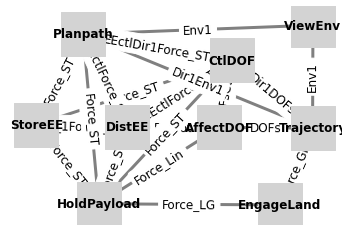

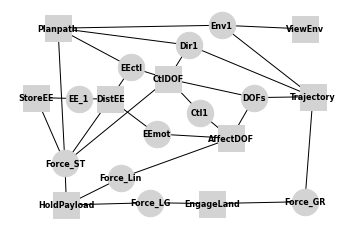

In [7]:
%matplotlib inline
rd.graph.show(mdl, pos=graph_pos, gtype='normal')
rd.graph.show(mdl, pos=bipartite_pos)

## Network Model

A network model can be used to compute network metrics and visualize network vulnerabilities.

We can calculate network metrics using calc_aspl, calc_modularity, and calc_robustness_coefficient in the `networks` module.

In [8]:
aspl = fs.networks.calc_aspl(mdl,gtype='normal')
q = fs.networks.calc_modularity(mdl,gtype='normal')
rc = fs.networks.calc_robustness_coefficient(mdl,gtype='normal')

print("ASPL: %.2f" % round(aspl, 2))
print("Modularity: %.2f" % round(q,2))
print("Robustness Coefficient: %.2f" % round(rc,2))

ASPL: 1.44
Modularity: 0.12
Robustness Coefficient: 95.53


Next, we visualize network vulnerabilities using find_bridging_nodes and find_high_degree_nodes.

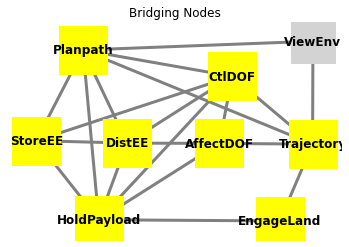

In [9]:
[bridging_nodes,fig_bridging_nodes,ax_bridging_nodes] = fs.networks.find_bridging_nodes(mdl,plot='on',gtype='normal', pos=graph_pos)
fig_bridging_nodes.savefig('bridgingnodes.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

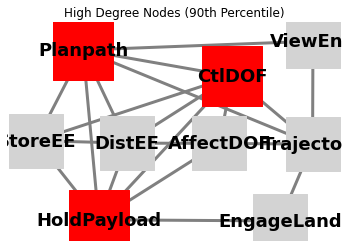

In [10]:
[high_degree_nodes,fig_high_degree_nodes,ax_high_degree_nodes] = fs.networks.find_high_degree_nodes(mdl,plot='on',gtype='normal', pos=graph_pos,scale=1.5)

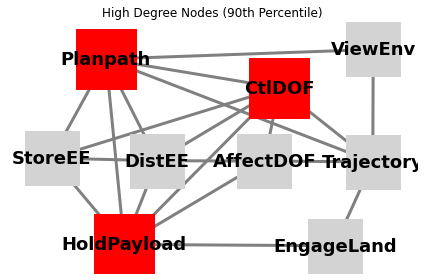

In [11]:
#fig_high_degree_nodes.subplots_adjust(left=0.2, right=1.3, top=1.0, bottom=0.2)
ax_high_degree_nodes.axis("off")
ax_high_degree_nodes.margins(0.08)
fig_high_degree_nodes.tight_layout()
fig_high_degree_nodes

In [12]:
fig_high_degree_nodes.savefig('highdegreenodes.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

High degree nodes (along with their degrees) and bridging nodes are also obtainable as lists.

In [13]:
print('Bridging Nodes:',bridging_nodes)
print('High Degree Nodes:',high_degree_nodes)

Bridging Nodes: ['AffectDOF', 'CtlDOF', 'DistEE', 'EngageLand', 'HoldPayload', 'Planpath', 'StoreEE', 'Trajectory']
High Degree Nodes: [('CtlDOF', 6), ('Planpath', 6), ('HoldPayload', 6)]


Finally, we can plot the degree distribution of the network using degree_dist.

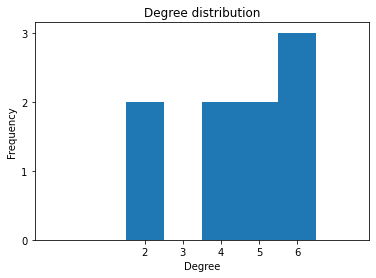

In [14]:
fig = fs.networks.degree_dist(mdl,gtype='normal')
fig.savefig('degreedist.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

The above analysis includes only function nodes. It is also possible to treat the bipartite graph (containing both functions and flows) as a unipartite-like graph and perform similar analysis on both function and flow nodes.

In [15]:
aspl = fs.networks.calc_aspl(mdl,gtype='bipartite')
q = fs.networks.calc_modularity(mdl,gtype='bipartite')
rc = fs.networks.calc_robustness_coefficient(mdl,gtype='bipartite')

print("ASPL, functions and flows: %.2f" % round(aspl, 2))
print("Modularity, functions and flows: %.2f" % round(q,2))
print("Robustness Coefficient, functions and flows: %.2f" % round(rc,2))

ASPL, functions and flows: 2.77
Modularity, functions and flows: 0.35
Robustness Coefficient, functions and flows: 81.41


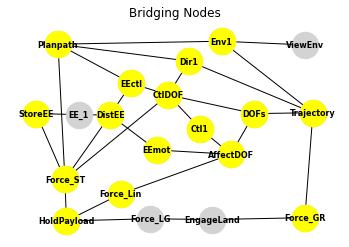

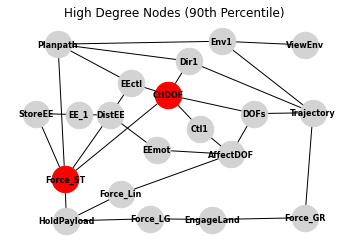

In [16]:
[bridging_nodes,fig_bridging_nodes,ax_bridging_nodes] = fs.networks.find_bridging_nodes(mdl,plot='on',gtype='bipartite', pos=bipartite_pos)
[high_degree_nodes,fig_high_degree_nodes,ax_high_degree_nodes] = fs.networks.find_high_degree_nodes(mdl,plot='on',gtype='bipartite', pos=bipartite_pos)

In [17]:
print('Bridging Nodes:',bridging_nodes)
print('High Degree Nodes:',high_degree_nodes)

Bridging Nodes: ['AffectDOF', 'Ctl1', 'CtlDOF', 'DOFs', 'Dir1', 'DistEE', 'EEctl', 'EEmot', 'Env1', 'Force_GR', 'Force_Lin', 'Force_ST', 'HoldPayload', 'Planpath', 'StoreEE', 'Trajectory']
High Degree Nodes: [('CtlDOF', 5), ('Force_ST', 5)]


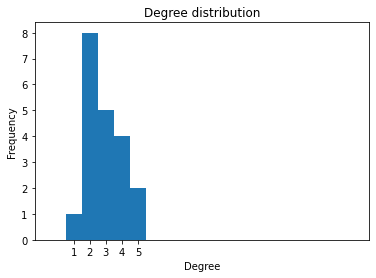

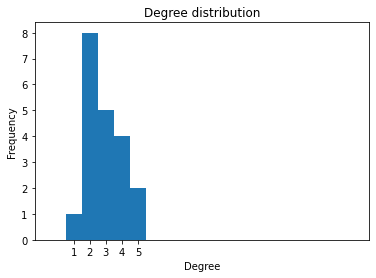

In [18]:
fs.networks.degree_dist(mdl,gtype='bipartite')

The SFF model can be simulated with options for simulation time, infection (failure) rate, and recovery (fix) rate. The start node can be selected or chosen randomly. Plotting includes an option for error bars. This models the system's response to a failure using an analogy of an epidemic spreading through a network.

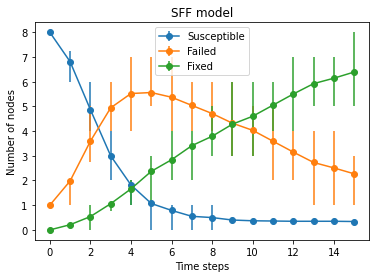

In [19]:
fig=fs.networks.sff_model(mdl,gtype='normal',endtime=15,pi=.3,pr=.1,start_node='AffectDOF',error_bar_option='on')
fig.savefig('sff_model.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

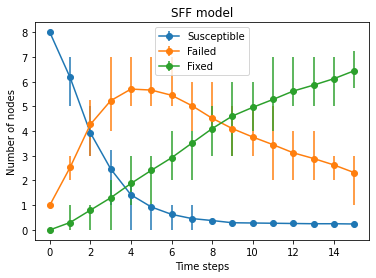

In [20]:
fig=fs.networks.sff_model(mdl,gtype='normal',endtime=15,pi=.3,pr=.1,start_node='random',error_bar_option='on')

## Static Model

In this demonstration, we will use a static representation of the system model to displaygraph views of fault scenarios and produce a static FMEA

The static model is located in `drone_mdl_static.py`.

In [21]:
from drone_mdl_static import Drone as Drone_Static

In design, it often helps to quantify the relative impact of fault scenarios. Here we produce a scenario-based FMEA to show which scenarios are most important in the model:

In [22]:
static_mdl = Drone_Static(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endclasses, mdlhists = fs.propagate.single_faults(static_mdl)

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 367.28it/s]


In [23]:
reshists, diffs, summaries = rd.process.hists(mdlhists)
static_fmea = rd.tabulate.fullfmea(endclasses, summaries)
static_fmea.sort_values('expected cost', ascending=False)

,degraded functions,degraded flows,rate,cost,expected cost
"StoreEE nocharge, t=1","[StoreEE, DistEE, CtlDOF, Planpath, Trajectory...","[Force_ST, Force_Lin, Force_GR, Force_LG, EE_1...",0.00001,183300.0,183300.0
"Planpath degloc, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",0.000008,193000.0,154400.0
"DistEE short, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",0.000003,186000.0,55800.0
"AffectDOF ctlbreak, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",0.000002,184000.0,36800.0
"AffectDOF ctlup, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",0.000002,183500.0,36700.0
"DistEE break, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",0.000002,183000.0,36600.0
"CtlDOF noctl, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",0.000002,183000.0,36600.0
"AffectDOF short, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EE_1...",0.000001,186200.0,18620.0
"AffectDOF mechbreak, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",0.000001,183500.0,18350.0
"AffectDOF openc, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",0.000001,183200.0,18320.0


In [24]:
print(static_fmea.sort_values('expected cost', ascending=False).to_latex())

\begin{tabular}{llllll}
\toprule
{} &                                 degraded functions &                                     degraded flows &      rate &      cost & expected cost \\
\midrule
StoreEE nocharge, t=1       &  [StoreEE, DistEE, CtlDOF, Planpath, Trajectory... &  [Force\_ST, Force\_Lin, Force\_GR, Force\_LG, EE\_1... &   0.00001 &  183300.0 &      183300.0 \\
Planpath degloc, t=1        &  [DistEE, CtlDOF, Planpath, Trajectory, EngageL... &  [Force\_ST, Force\_Lin, Force\_GR, Force\_LG, EEmo... &  0.000008 &  193000.0 &      154400.0 \\
DistEE short, t=1           &  [DistEE, CtlDOF, Planpath, Trajectory, EngageL... &  [Force\_ST, Force\_Lin, Force\_GR, Force\_LG, EEmo... &  0.000003 &  186000.0 &       55800.0 \\
AffectDOF ctlbreak, t=1     &  [DistEE, AffectDOF, CtlDOF, Planpath, Trajecto... &  [Force\_ST, Force\_Lin, Force\_GR, Force\_LG, EEmo... &  0.000002 &  184000.0 &       36800.0 \\
AffectDOF ctlup, t=1        &  [DistEE, AffectDOF, CtlDOF, Planpath, Trajecto... 

We can in turn visualize these faults on the graph representation of the system. Here we will focus on the break of one of the rotors in the AffectDOF function, the effects of which are shown below:

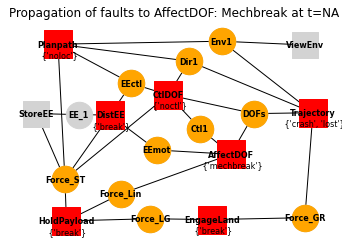

In [25]:
static_mdl = Drone_Static(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.one_fault(static_mdl,'AffectDOF', 'mechbreak', gtype='bipartite')
fig, ax = rd.graph.show(resgraph, pos = bipartite_pos, faultscen='AffectDOF: Mechbreak', time='NA', scale=1, gtype='bipartite')
fig.savefig('static_propagation.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

## Dynamic Model

In the dynamic model, we add time ranges and dynamic behaviors to generate behavior-over-time graphs and dynamic/phase-based FMEAs.

This model is located in `drone_mdl_dynamic.py`.

In [26]:
from drone_mdl_dynamic import Drone as Drone_Dynamic

Here we can see how the system operates over time in the nominal case:

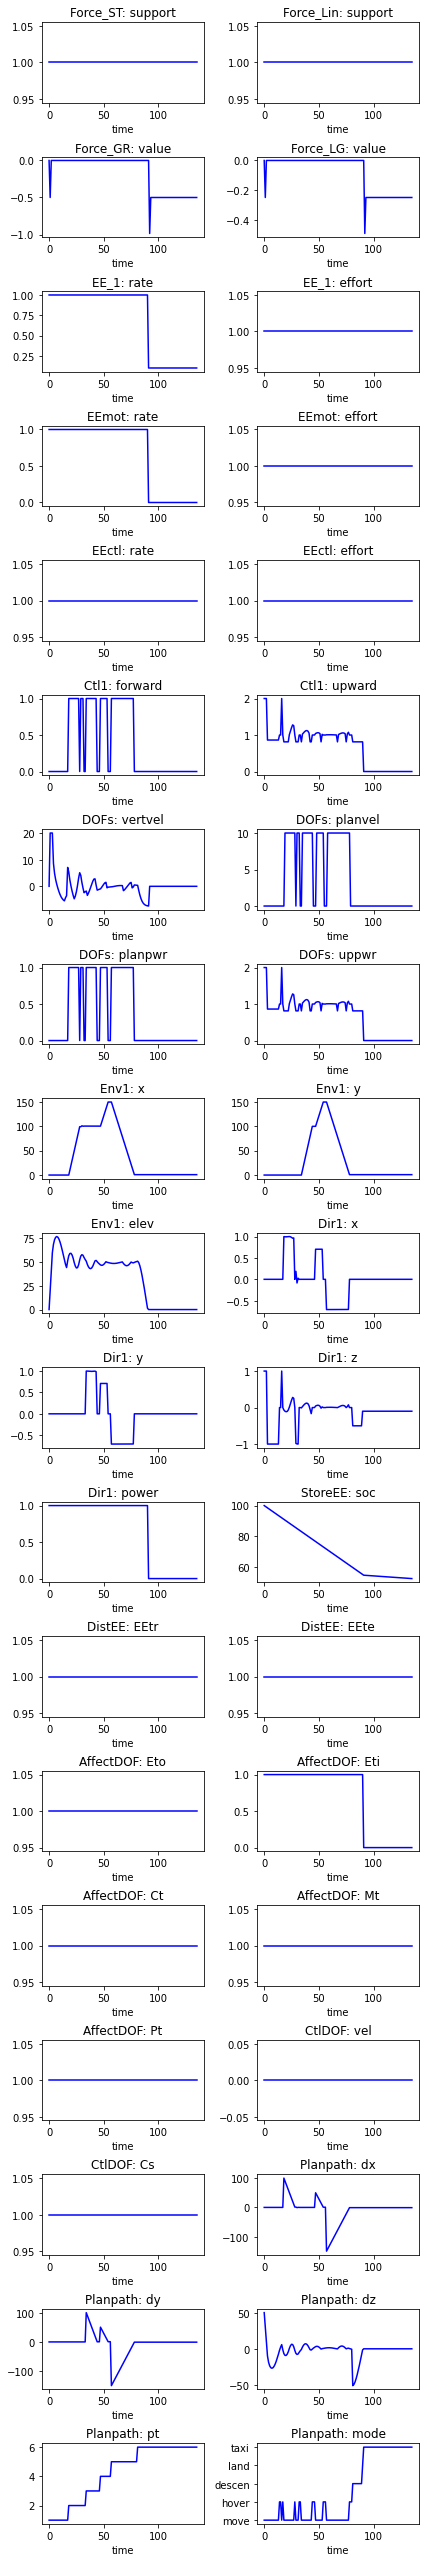

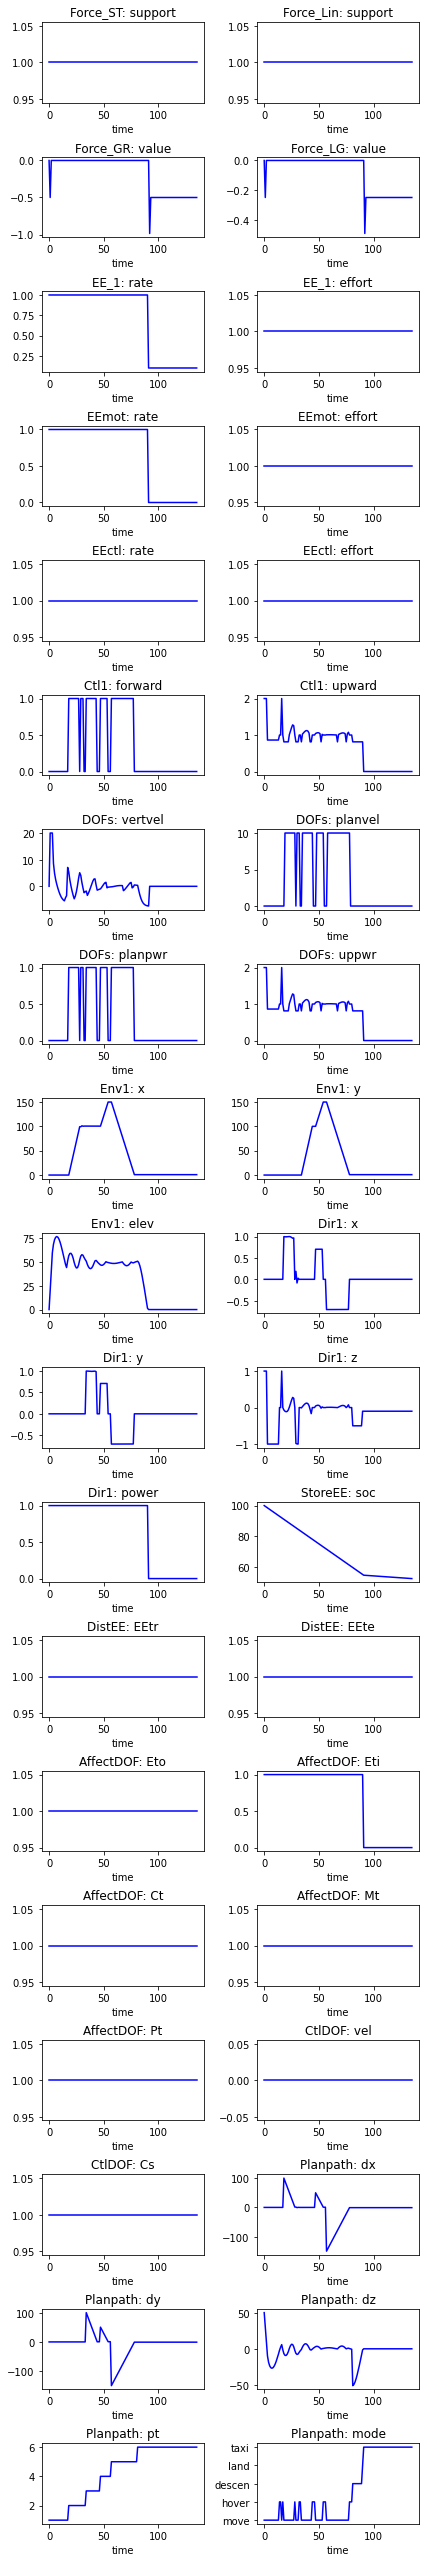

In [27]:
# Note: because of the complicated functions, the model must be re-instantiated for each function in order to work in this case
dynamic_mdl = Drone_Dynamic(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.nominal(dynamic_mdl)
rd.plot.mdlhistvals(mdlhist)

As shown below, in the case of the break in the AffectDOF function, the system crashes:

In [28]:
dynamic_mdl = Drone_Dynamic(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.one_fault(dynamic_mdl,'AffectDOF', 'mechbreak', time=50)

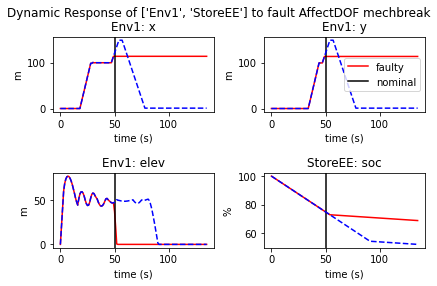

In [29]:
fig= rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']}, units=['m','m','m','%'],legend=False, returnfig=True, timelabel='time (s)')

ax = fig.axes[1]
ax.legend(['faulty', 'nominal'], loc='right')

fig.savefig("fault_behavior.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Finally, we can see how the cost function of this scenario changes over time. As shown, when the fault is injected early, it has a lower cost because it crashes at the landing pad and not in a dangerous area. When it is injected at the end, the cost is minimal because the drone has already landed.

In [30]:
mdl_quad_comp = Drone_Dynamic(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
quad_comp_app = SampleApproach(mdl_quad_comp, faults=[('AffectDOF', 'mechbreak')],defaultsamp={'samp':'evenspacing','numpts':5})
quad_comp_endclasses, quad_comp_mdlhists = fs.propagate.approach(mdl_quad_comp, quad_comp_app, staged=True)

SCENARIOS COMPLETE: 100%|██████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.60it/s]


In [31]:
quad_comp_mdlhists['AffectDOF mechbreak, t=20.0']['flows']['Env1']['x'][-1]

9.977765842580308

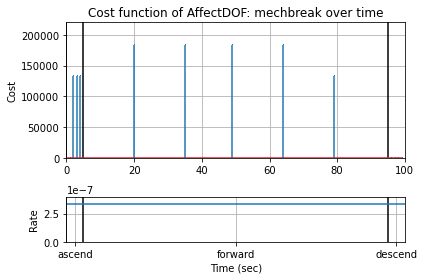

In [32]:
rd.plot.samplecost(quad_comp_app, quad_comp_endclasses, ('AffectDOF', 'mechbreak'))
fig = plt.gcf()
fig.savefig("cost_over_time.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [33]:
quad_comp_endclasses

{'AffectDOF mechbreak, t=0.0': {'rate': 9.259259259259263e-10,
  'cost': 500,
  'expected cost': 0.046296296296296315},
 'AffectDOF mechbreak, t=1.0': {'rate': 9.259259259259263e-10,
  'cost': 500,
  'expected cost': 0.046296296296296315},
 'AffectDOF mechbreak, t=2.0': {'rate': 9.259259259259263e-10,
  'cost': 133500,
  'expected cost': 12.361111111111114},
 'AffectDOF mechbreak, t=3.0': {'rate': 9.259259259259263e-10,
  'cost': 133500,
  'expected cost': 12.361111111111114},
 'AffectDOF mechbreak, t=4.0': {'rate': 9.259259259259263e-10,
  'cost': 133500,
  'expected cost': 12.361111111111114},
 'AffectDOF mechbreak, t=20.0': {'rate': 1.6666666666666674e-08,
  'cost': 183500,
  'expected cost': 305.8333333333335},
 'AffectDOF mechbreak, t=35.0': {'rate': 1.6666666666666674e-08,
  'cost': 183500,
  'expected cost': 305.8333333333335},
 'AffectDOF mechbreak, t=49.0': {'rate': 1.6666666666666674e-08,
  'cost': 183500,
  'expected cost': 305.8333333333335},
 'AffectDOF mechbreak, t=64.0':

## Hierarchical Model

In the hierarchical model, we can use the simulation to compare system architectures. First by seeing how faults effect the behaviors in each architechture, then by seing how it affects the overall system resilience. 

This model is located in `drone_mdl_hierarchical.py`.

In [34]:
from drone_mdl_hierarchical import Drone as Drone_Hierarchical

First, we can model how the quadrotor architecture behaves under faults--in this case, identically to the non-hierarchical model:

In [35]:
hierarchical_model = Drone_Hierarchical(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
endresults, resgraph, mdlhist = fs.propagate.one_fault(hierarchical_model,'AffectDOF', 'RFmechbreak', time=50)

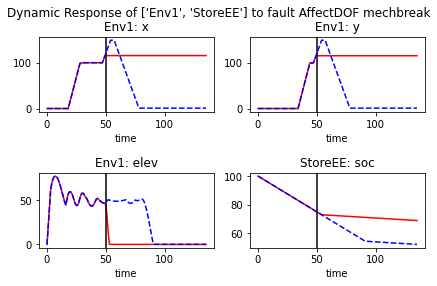

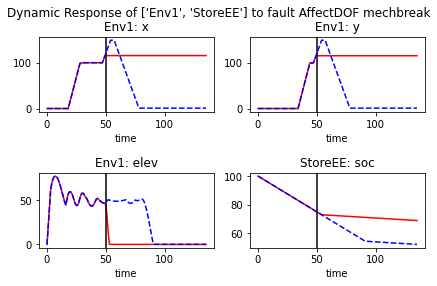

In [36]:
rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']}, legend=False)

Then we can see how the octorotor architecture performs in the same case:

In [37]:
hierarchical_model = Drone_Hierarchical(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})
endresults, resgraph, mdlhist = fs.propagate.one_fault(hierarchical_model,'AffectDOF', 'RFmechbreak', time=50)

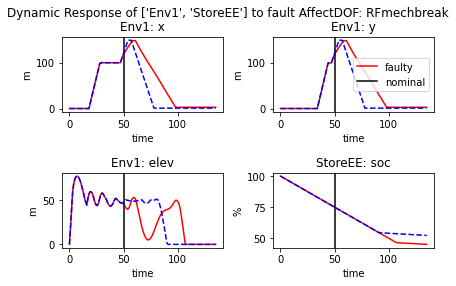

In [38]:
fig= rd.plot.mdlhistvals(mdlhist,'AffectDOF: RFmechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']}, units=['m','m','m','%'], legend=False, returnfig=True)

ax = fig.axes[1]
ax.legend(['faulty', 'nominal'], loc='right')

fig.savefig("red_fault_behavior.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, the octorotor architecture enables the quadrotor to recover from the fault and land.

Next, we can compare how each architecture mitigates the set of faults that originiate in each function:
### Quadcopter Resilience

Here we quantify the expected costs of faults originiating in the quadcopter architecture:

In [39]:
mdl_quad = Drone_Hierarchical(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
mdl_quad.fxns['AffectDOF'].faultmodes
quad_faults = [('AffectDOF', fault) for fault in list(mdl_quad.fxns['AffectDOF'].faultmodes.keys())]

In [40]:
quad_app = SampleApproach(mdl_quad, faults=quad_faults)
quad_endclasses, quad_mdlhists = fs.propagate.approach(mdl_quad, quad_app, staged=True)

SCENARIOS COMPLETE:  10%|█████▊                                                       | 10/104 [00:11<01:57,  1.25s/it]Exception ignored in: <function BaseGeometry.__del__ at 0x00000113CADE4C10>
Traceback (most recent call last):
  File "C:\Users\dhulse\Anaconda3\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\dhulse\Anaconda3\lib\site-packages\shapely\geometry\base.py", line 194, in _empty
    self._lgeos.GEOSGeom_destroy(self.__geom__)
KeyboardInterrupt: 
SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 104/104 [01:07<00:00,  1.54it/s]


In [41]:
quad_tab = rd.tabulate.simplefmea(quad_endclasses)
quad_tab.sort_values('expected cost', ascending=False)

,rate,cost,expected cost
"AffectDOF LRctlbreak, t=49.0",1.666667e-07,186800.0,3113.333333
"AffectDOF RRctlbreak, t=49.0",1.666667e-07,186800.0,3113.333333
"AffectDOF LFctlbreak, t=49.0",1.666667e-07,186800.0,3113.333333
"AffectDOF RFctlbreak, t=49.0",1.666667e-07,186800.0,3113.333333
"AffectDOF LFctlup, t=49.0",1.666667e-07,186300.0,3105.000000
...,...,...,...
"AffectDOF RRpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF RFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LRpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LFpropwarp, t=97.0",6.944444e-10,200.0,0.013889


Based on this model, we can calculate some metrics that quantify how resilient the system was to the set of faults, such as the cost of resilience:

In [42]:
quad_res = sum(quad_tab['expected cost'])
quad_res

45564.95370370373

The overall rate of crashes:

In [43]:
quad_crashes = quad_tab[quad_tab['cost']>100000]
quad_rate = sum(quad_crashes['rate'])
quad_rate

2.3796296296296308e-06

The number of crashes:

In [44]:
quad_num_crashes = len(quad_crashes['rate'])
quad_num_crashes

46

The percentage of crashes:

In [45]:
quad_perc_crashes = len(quad_crashes['rate'])/len(quad_tab['rate'])
quad_perc_crashes

0.4380952380952381

### Octocopter Resilience

Here we quantify the expected costs of faults originiating in the octocopter architecture:

In [46]:
mdl_oct = Drone_Hierarchical(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})
mdl_oct.fxns['AffectDOF'].faultmodes
oct_faults = [('AffectDOF', fault) for fault in list(mdl_oct.fxns['AffectDOF'].faultmodes.keys())]

In [47]:
oct_app = SampleApproach(mdl_oct, faults=oct_faults)
oct_endclasses, oct_mdlhists = fs.propagate.approach(mdl_oct, oct_app, staged=True)

SCENARIOS COMPLETE: 100%|██████████| 208/208 [03:10<00:00,  1.09it/s]


In [48]:
oct_tab = rd.tabulate.simplefmea(oct_endclasses)
oct_tab.sort_values('expected cost', ascending=False)

,rate,cost,expected cost
"AffectDOF LRshort, t=49.0",8.333333e-08,191800.0,1598.333333
"AffectDOF RF2short, t=49.0",8.333333e-08,191800.0,1598.333333
"AffectDOF LR2short, t=49.0",8.333333e-08,191800.0,1598.333333
"AffectDOF LFshort, t=49.0",8.333333e-08,191800.0,1598.333333
"AffectDOF RRshort, t=49.0",8.333333e-08,191800.0,1598.333333
...,...,...,...
"AffectDOF LF2propwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF RRpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF RR2propwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF RF2propwarp, t=97.0",6.944444e-10,200.0,0.013889


Based on this model, we can calculate some metrics that quantify how resilient the system was to the set of faults, such as the cost of resilience:

In [49]:
oct_res = sum(oct_tab['expected cost'])
oct_res

19358.870370370398

The overall rate of crashes:

In [50]:
oct_crashes = oct_tab[oct_tab['cost']>100000]
oct_rate = sum(oct_crashes['rate'])
oct_rate

7.037037037037039e-07

Number of crashes:

In [51]:
oct_num_crashes = len(oct_crashes['rate'])
oct_num_crashes

16

Percent of crashes:

In [52]:
oct_perc_crashes = len(oct_crashes['rate'])/len(oct_tab['rate'])
oct_perc_crashes

0.07655502392344497

In [53]:
oct_crashes[35:]

,rate,cost,expected cost
